In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LayerNormalization, Dropout, Reshape
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/pamap2_HAR_raw.csv')

In [5]:
# Linear Interpolation and drop NANs
sensor_columns = [col for col in df.columns if col not in ['timestamp', 'activityID', 'activity_name']]
sensor_data = df[sensor_columns]
sensor_data = sensor_data.interpolate(method='linear', axis=0)
sensor_data = sensor_data.dropna()

In [6]:
# Feature Engineering
sensor_data['hand_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_hand_3D_acceleration_1']**2 +
    sensor_data['IMU_hand_3D_acceleration_2']**2 +
    sensor_data['IMU_hand_3D_acceleration_3']**2
)
sensor_data['chest_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_acceleration_1']**2 +
    sensor_data['IMU_chest_3D_acceleration_2']**2 +
    sensor_data['IMU_chest_3D_acceleration_3']**2
)
sensor_data['chest_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_gyroscope_1']**2 +
    sensor_data['IMU_chest_3D_gyroscope_2']**2 +
    sensor_data['IMU_chest_3D_gyroscope_3']**2
)
sensor_data['chest_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_magnetometer_1']**2 +
    sensor_data['IMU_chest_3D_magnetometer_2']**2 +
    sensor_data['IMU_chest_3D_magnetometer_3']**2
)
sensor_data['ankle_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_acceleration_1']**2 +
    sensor_data['IMU_ankle_3D_acceleration_2']**2 +
    sensor_data['IMU_ankle_3D_acceleration_3']**2
)
sensor_data['ankle_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_gyroscope_1']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_2']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_3']**2
)
sensor_data['ankle_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_magnetometer_1']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_2']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_3']**2
)

# Drop original columns
cols_to_drop = [
    'IMU_chest_3D_acceleration_1', 'IMU_chest_3D_acceleration_2', 'IMU_chest_3D_acceleration_3',
    'IMU_hand_3D_acceleration_1', 'IMU_hand_3D_acceleration_2', 'IMU_hand_3D_acceleration_3',
    'IMU_chest_3D_gyroscope_1', 'IMU_chest_3D_gyroscope_2', 'IMU_chest_3D_gyroscope_3',
    'IMU_hand_3D_gyroscope_1', 'IMU_hand_3D_gyroscope_2', 'IMU_hand_3D_gyroscope_3',
    'IMU_chest_3D_magnetometer_1', 'IMU_chest_3D_magnetometer_2', 'IMU_chest_3D_magnetometer_3',
    'IMU_ankle_3D_acceleration_1', 'IMU_ankle_3D_acceleration_2', 'IMU_ankle_3D_acceleration_3',
    'IMU_ankle_3D_gyroscope_1', 'IMU_ankle_3D_gyroscope_2', 'IMU_ankle_3D_gyroscope_3',
    'IMU_ankle_3D_magnetometer_1', 'IMU_ankle_3D_magnetometer_2', 'IMU_ankle_3D_magnetometer_3'
]
sensor_data = sensor_data.drop(cols_to_drop, axis=1)

In [7]:
# Min-Max Scaling
scaler = MinMaxScaler()
sensor_data_scaled = scaler.fit_transform(sensor_data)
sensor_data_scaled = pd.DataFrame(sensor_data_scaled, columns=sensor_data.columns)

In [8]:
# Reintroduce for splitting
sensor_data_scaled['timestamp'] = df['timestamp']
sensor_data_scaled['activityID'] = df['activityID']
sensor_data_scaled['activity_name'] = df['activity_name']

In [9]:
# Train-Test Split (80% train, 20% test)
train_threshold = df['timestamp'].quantile(0.8)
train_data = sensor_data_scaled[sensor_data_scaled['timestamp'] < train_threshold].drop(columns=['timestamp', 'activityID', 'activity_name'])
test_data = sensor_data_scaled[sensor_data_scaled['timestamp'] >= train_threshold].drop(columns=['timestamp', 'activityID', 'activity_name'])


In [10]:
# Create sequences for Transformer input
def create_sequences(data, seq_length=20):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i:i + seq_length].values)
    return np.array(sequences)

X_train = create_sequences(train_data)
X_test = create_sequences(test_data)

# Transformer Architecture

In [11]:
from tensorflow.keras.layers import MultiHeadAttention
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_dim, input_shape):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(input_shape[-1])
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(0.1)
        self.dropout2 = Dropout(0.1)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerAutoencoder(Model):
    def __init__(self, input_shape, num_heads=4, ff_dim=128):
        super(TransformerAutoencoder, self).__init__()
        self.encoder_layer = TransformerEncoderLayer(num_heads=num_heads, ff_dim=ff_dim, input_shape=input_shape)
        self.decoder_layer = TransformerEncoderLayer(num_heads=num_heads, ff_dim=ff_dim, input_shape=input_shape)
        self.dense = Dense(input_shape[1], activation='linear')
        self.reshape_layer = Reshape(input_shape)

    def call(self, inputs, training=None):
        encoded = self.encoder_layer(inputs, training=training)
        decoded = self.decoder_layer(encoded, training=training)
        decoded = self.dense(decoded)
        decoded = self.reshape_layer(decoded)
        return decoded

seq_length = X_train.shape[1]
num_features = X_train.shape[2]
autoencoder = TransformerAutoencoder((seq_length, num_features))
autoencoder.compile(optimizer='adam', loss='mse')

In [12]:
history=autoencoder.fit(X_train, X_train, epochs=20, batch_size=32)

Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 0.0483
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 0.0014
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - loss: 7.7494e-04
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 4.8747e-04
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 3.2162e-04
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 2.5534e-04
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 1.9715e-04
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 1.6145e-04
Epoch 9/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 1.4167e-04
Epoch 10/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - loss: 1.1832e-04
Epoch 11/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 1.0242e-04
Epoch 12/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 9.2754e-05
Epoch 13/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - loss: 8.2487e-05
Epoch 14/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step 

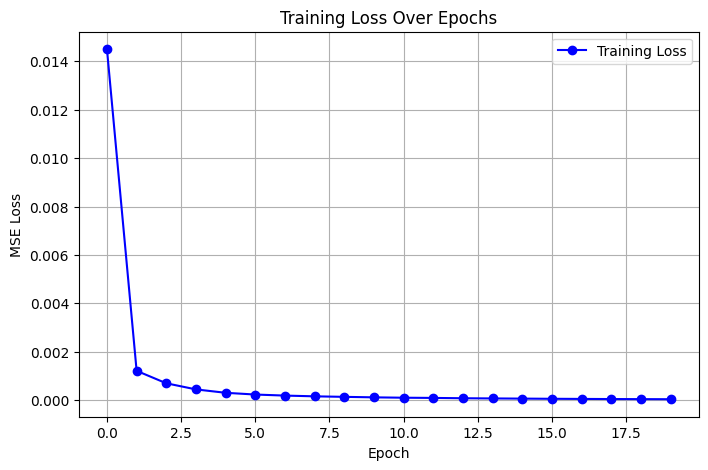

In [13]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [14]:
def compute_unsupervised_rewards(X):
    reconstructed = autoencoder.predict(X)
    reconstruction_error = np.mean(np.abs(X - reconstructed), axis=2)
    threshold = np.percentile(reconstruction_error, 95, axis=0, keepdims=True)
    rewards = (reconstruction_error > threshold).astype(int)
    return rewards

unsupervised_rewards = compute_unsupervised_rewards(X_train)
unsupervised_rewards = np.expand_dims(unsupervised_rewards, axis=-1)

675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step


# PPO Agent

In [18]:
class PPOAgent(tf.keras.Model):
    def __init__(self, num_actions):
        super(PPOAgent, self).__init__()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(64, activation='relu')
        self.policy_logits = Dense(num_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.policy_logits(x)

num_actions = 2
ppo_model = PPOAgent(num_actions)

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

policy_losses = []
policy_entropies = []

class PPOTrainer:
    def __init__(self, model, gamma=0.99, learning_rate=0.0001):
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.gamma = gamma

    def train(self, X, rewards, epochs=10):
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                logits = self.model(X)
                policy_out = tf.nn.softmax(logits)

                # One-hot encoding for actions
                rewards_binary = np.where(rewards > 0, 1, 0).astype(int)
                rewards_binary = rewards_binary.reshape(rewards_binary.shape[0], rewards_binary.shape[1])

                action_probs = tf.reduce_sum(policy_out * tf.one_hot(rewards_binary, depth=2), axis=-1)

                # PPO Loss (negative log likelihood)
                loss = -tf.reduce_mean(tf.math.log(action_probs + 1e-10) * tf.cast(rewards_binary, tf.float32))

                # Policy Entropy (measure of exploration)
                entropy = -tf.reduce_mean(tf.reduce_sum(policy_out * tf.math.log(policy_out + 1e-10), axis=-1))

            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

            policy_losses.append(loss.numpy())
            policy_entropies.append(entropy.numpy())

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}, Entropy: {entropy.numpy():.4f}")

In [20]:
# Train PPO
ppo_trainer = PPOTrainer(ppo_model)
ppo_trainer.train(X_train, unsupervised_rewards, epochs=10)

Epoch 1/10, Loss: 0.0258, Entropy: 0.6738
Epoch 2/10, Loss: 0.0253, Entropy: 0.6719
Epoch 3/10, Loss: 0.0249, Entropy: 0.6699
Epoch 4/10, Loss: 0.0245, Entropy: 0.6679
Epoch 5/10, Loss: 0.0241, Entropy: 0.6657
Epoch 6/10, Loss: 0.0237, Entropy: 0.6634
Epoch 7/10, Loss: 0.0233, Entropy: 0.6611
Epoch 8/10, Loss: 0.0230, Entropy: 0.6586
Epoch 9/10, Loss: 0.0226, Entropy: 0.6561
Epoch 10/10, Loss: 0.0222, Entropy: 0.6535


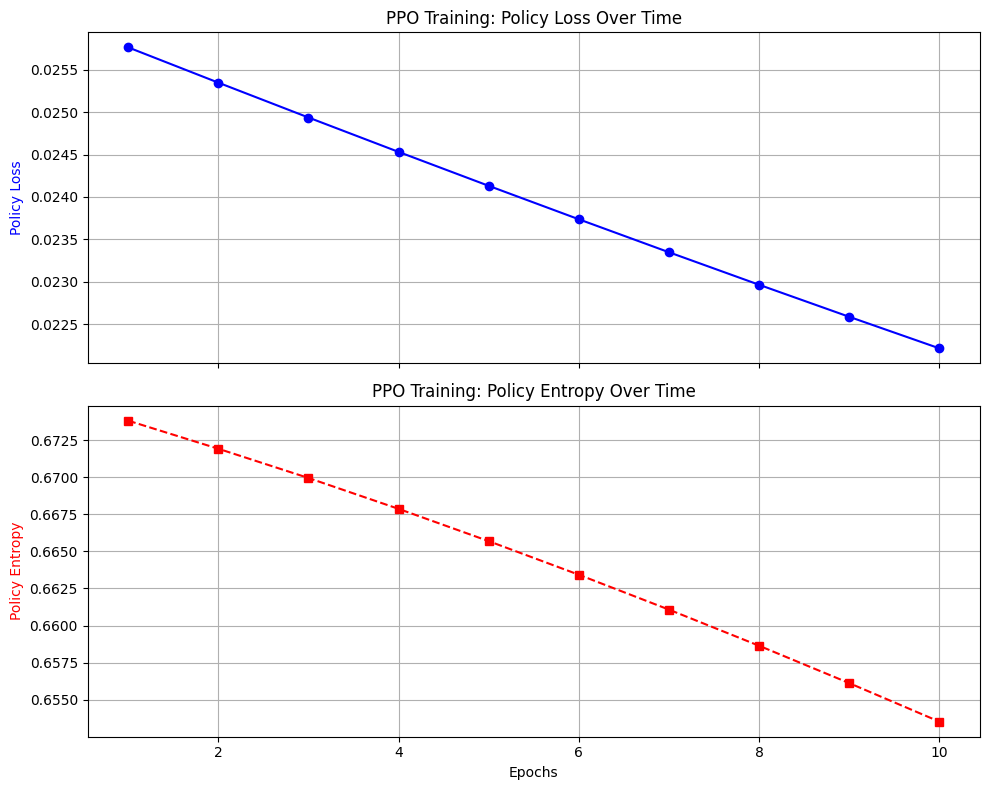

In [21]:
# Create two separate subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Plot Policy Loss
axes[0].plot(range(1, len(policy_losses) + 1), policy_losses, marker='o', linestyle='-', color='blue')
axes[0].set_ylabel("Policy Loss", color='blue')
axes[0].set_title("PPO Training: Policy Loss Over Time")
axes[0].grid(True)

# Plot Policy Entropy
axes[1].plot(range(1, len(policy_entropies) + 1), policy_entropies, marker='s', linestyle='--', color='red')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Policy Entropy", color='red')
axes[1].set_title("PPO Training: Policy Entropy Over Time")
axes[1].grid(True)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


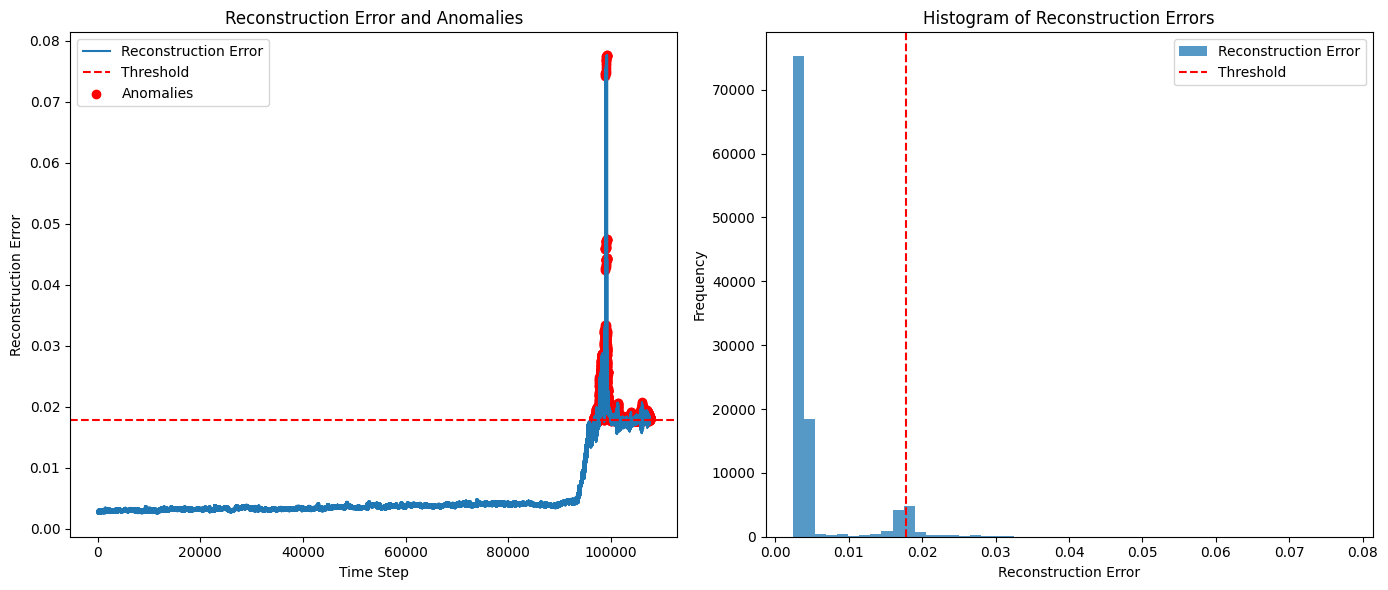

Total number of anomalies detected: 5380
Indices of anomalous points: [ 96739  96758  96759 ... 107594 107597 107599]
Reconstruction errors of anomalous points: [0.01820124 0.01815101 0.01828653 ... 0.01791983 0.01795951 0.01812524]


In [22]:
reconstructed_test = autoencoder.predict(X_test)
reconstruction_error_test = np.mean(np.abs(X_test - reconstructed_test), axis=2)

threshold = np.percentile(reconstruction_error_test, 95, axis=0, keepdims=True)

anomalies = (reconstruction_error_test > threshold).astype(int)
total_anomalies = np.sum(anomalies)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(reconstruction_error_test.flatten(), label='Reconstruction Error')
plt.axhline(y=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies.flatten() == 1), reconstruction_error_test.flatten()[anomalies.flatten() == 1], color='r', label='Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error and Anomalies')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(reconstruction_error_test.flatten(), bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(x=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total number of anomalies detected: {total_anomalies}")

anomalous_points = np.where(anomalies.flatten() == 1)[0]
print("Indices of anomalous points:", anomalous_points)
print("Reconstruction errors of anomalous points:", reconstruction_error_test.flatten()[anomalous_points])

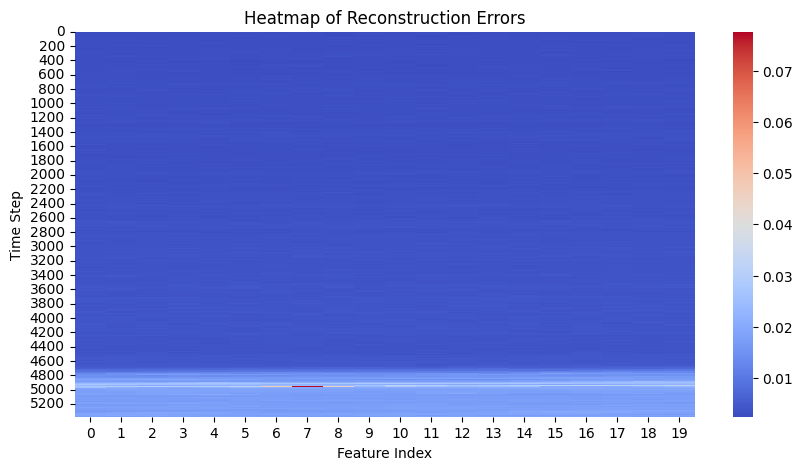

In [23]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(reconstruction_error_test, cmap="coolwarm", annot=False, cbar=True)
plt.xlabel("Feature Index")
plt.ylabel("Time Step")
plt.title("Heatmap of Reconstruction Errors")
plt.show()


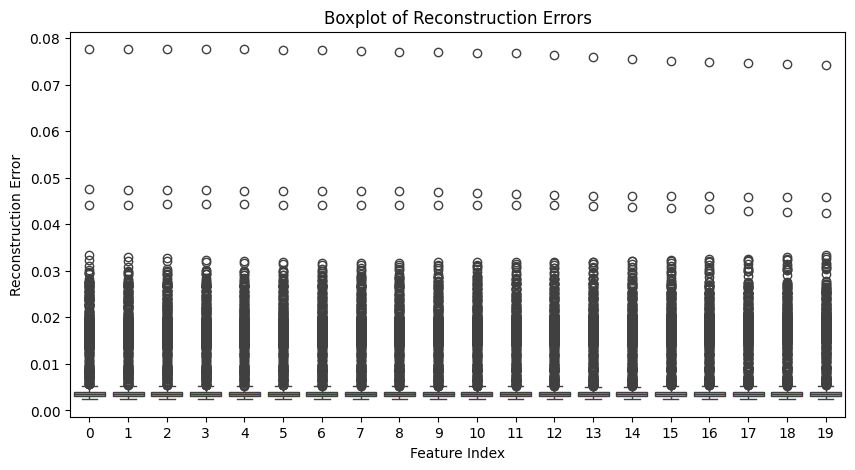

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=reconstruction_error_test)
plt.xlabel("Feature Index")
plt.ylabel("Reconstruction Error")
plt.title("Boxplot of Reconstruction Errors")
plt.show()


<ipython-input-25-3a1f2f252419>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(reconstruction_error_test.flatten(), shade=True, label="Reconstruction Error Density", color='blue')


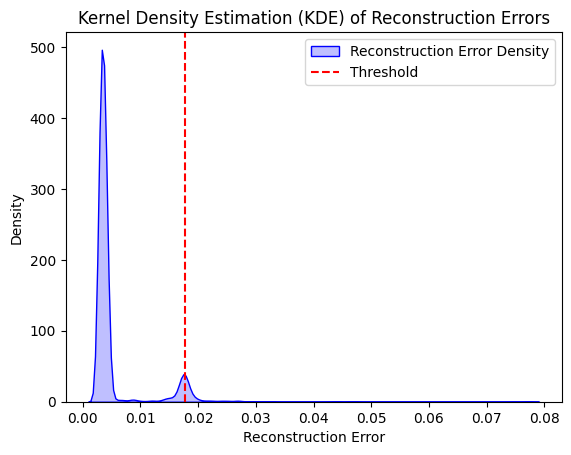

In [25]:
sns.kdeplot(reconstruction_error_test.flatten(), shade=True, label="Reconstruction Error Density", color='blue')
plt.axvline(x=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Kernel Density Estimation (KDE) of Reconstruction Errors")
plt.legend()
plt.show()
